## DenseNet

DenseNet is a convolutional neural network structure that proposed by Huang et al. (2016). The link is https://arxiv.org/abs/1608.06993. Dense Connections concat channel layers on top of each other so that the gradient passing is more convenient similar to the idea of ResNet. Also, the information can be accumulated and provide better intuition for later layers to make predictions.

### Structure
DenseNet uses "densely-connected" blocks.

Assume that l is the index of current layer, $H_{ℓ}(·)$ can be a composite function of operations such as Batch Normalization (BN), rectified linear units (ReLU), Pooling, or Convolution (Conv). They denote the output of the ℓth layer as $x_{ℓ}$.

$x_{ℓ} = H_{ℓ}([x_{0},x_{1},...,x_{ℓ−1}])$

where $[x0,x1,...,x_{ℓ−1}]$ refers to the concatenation of the feature-maps produced in layers $0$,...,$ℓ−1$

<br/>
<br/>

<img src="./images/DN1.png" style="zoom:35%;"/>

<img src="./images/DN2.png" style="zoom:100%;"/>

In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch.nn import functional as F
import matplotlib.pyplot as plt
import math

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
device

device(type='cuda')

## Dataset - CIFAR10

CIFAR 10 is a dataset that contains 32 * 32 (W*H) * 3 (channel) images that can be categorized into 10 categories:
('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
batch_size = 128

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

loss_list = []
accuracy_list = []
epoch_list = []

train_data = datasets.CIFAR10(root='./resources/cifar10', train=True, transform=transform_train, download=True)
test_dataset = datasets.CIFAR10(root='./resources/cifar10', train=False, transform=transform_test, download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, generator=torch.Generator(device=device))

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# CIFAR-10 dataset consists of 32 * 32 RGB channel images.
# because batch size is 64, the inputs shape should be (batch, channel, height, width), which is (64, 3, 32, 32)

inputs, classes = next(iter(train_loader))
inputs.shape, classes.shape

(torch.Size([128, 3, 32, 32]), torch.Size([128]))

In [5]:
## Concat Tensors
## Because we need to concat feature maps, we need to use functions in torch to concat tensors

r1 = torch.randn(2, 3, 2)
r2 = torch.randn(2, 3, 2)

r3 = torch.cat((r1, r2), dim=1)
r3.shape

torch.Size([2, 6, 2])

## BottleNeck, DenseBlock, and TransitionLayer

### BottleNeck Layer

BottleNeck layer is a small component that can be used to consist of a larger component named "DenseBlock". For the BottleNeck, below is a great illustration comes from (https://zhuanlan.zhihu.com/p/67311529). The input goes through a BatchNorm2D, a ReLU, and a Conv2D kernel 1*1, in_channel=in_channel, out_channel=4 * k, where k is the growth rate. Since we are keep concating layers in channel axis, the channel gets bigger and bigger. Each time we go through an BottleNeck layer, the channel goes from (in_channel) to (in_channel + k)
<br/>

<img src="./images/DN4.png" style="zoom:45%;"/>


In [6]:
class BottleNeck(nn.Module):
    def __init__(self, in_channels, k, p=0.05):
        super(BottleNeck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=4 * k, kernel_size=1, stride=1, bias=False)

        self.bn2 = nn.BatchNorm2d(4 * k)
        self.conv2 = nn.Conv2d(in_channels=4 * k, out_channels=k, kernel_size=3, stride=1, padding=1, bias=False)

        self.dropout = nn.Dropout2d(p)


    def forward(self, x):
        x1 = self.bn1(x)
        x1 = F.relu(x1)
        x1 = self.conv1(x1)

        x2 = self.bn2(x1)
        x2 = F.relu(x2)
        x2 = self.conv2(x2)

        x2 = self.dropout(x2)

        return torch.cat((x2, x), dim=1)

## DenseBlock

DenseBlock is a sequential combination of BottleNeck Layers. In the following table provided by the original paper, for DenseNet121, first DenseBlock (1) consists of 6 BottleNeck Layers.

<br/>

<img src="./images/DN3.png" style="zoom:75%;"/>

In [7]:
class DenseBlock(nn.Module):
    def __init__(self, in_channels, num_dense_block, k):
        super(DenseBlock, self).__init__()
        self.bottleNecks = self._make_dense_layer(in_channels, num_dense_block, k)


    def _make_dense_layer(self, in_channels, num_dense_block, k):
        dm = []
        for i in range(0, num_dense_block):
            dm1 = BottleNeck(in_channels + (k * i), k)
            dm.append(dm1)
        return nn.Sequential(*dm)

    def forward(self, x):
        x = self.bottleNecks(x)

        return x

## Transition Layer

Because we keep adding more layers by the growth rate after going through each BottleNeck Dense Connection, we would like to shrink the number of channel in each transitional layer. In the original paper, they shrink the num of channel by half for each transition layer go through. In the above table, there are 3 transition layers for DenseNet121.

In [8]:
class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels, in_size, out_size):
        super(TransitionLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, bias=False)
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)


    def forward(self, x):
        x = F.relu(self.bn1(x))
        x = self.conv1(x)
        x = self.avg_pool(x)
        return x

# DenseNet121

From the table below, we can observe the structure of the DenseNet121. It uses k (growth rate) as 32. It first go through a Conv2D with 7 * 7 kernel and stride 2. However, since the CIFAR-10 only has 32 * 32 in width and height, I think it is better to use a smaller kernel size and stride 1, so I made small modification. Also, since the image is too small, I didn't use the max pooling layer in the beginning. We also differ slightly for the output size (width * height) part, as I don't want to pad the 32 * 32 image to 112 * 112. So instead of going 112 * 112 -> 56 * 56 -> 28 * 28, etc., we are going from 32 * 32 -> 16 * 16 -> 8 * 8 -> 4 * 4 -> 1 * 1 -> fc layer.

There are 3 (DenseBlock + Transition Layer) combinations and then there is a single DenseBlock (4) at the bottom. After that I made a batch norm which didn't appear in the original paper.  Then we will do a global average pooling (this means that we eliminate height and width dimensions by averaging them but keep the channel dimension for now). After that, we shrink the tensor to flat and pass that to 2 LinearLayers for classification.

<br/>

<img src="./images/DN3.png" style="zoom:75%;"/>

In [9]:
class DenseNet121(nn.Module):
    def __init__(self, in_channels, in_size, num_out_classes, num_init_channel=32, k=32):
        super(DenseNet121, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=num_init_channel, kernel_size=3, stride=1, padding=math.ceil((34 - in_size) / 2), bias=False)

        num_db1 = 6
        num_output_channel1 = k * num_db1 + num_init_channel
        num_output_channel_to_next1 = math.floor(num_output_channel1 / 2)
        self.db1 = DenseBlock(in_channels=num_init_channel, num_dense_block=num_db1, k=k)
        self.tl1 = TransitionLayer(in_channels=num_output_channel1, out_channels=num_output_channel_to_next1, in_size=32, out_size=16)

        num_db2 = 12
        num_output_channel2 = num_output_channel_to_next1 + k * num_db2
        num_output_channel_to_next2 = math.floor(num_output_channel2 / 2)
        self.db2 = DenseBlock(in_channels=num_output_channel_to_next1, num_dense_block=num_db2, k=k)
        self.tl2 = TransitionLayer(in_channels=num_output_channel2, out_channels=num_output_channel_to_next2, in_size=16, out_size=8)

        num_db3 = 24
        num_output_channel3 = num_output_channel_to_next2 + k * num_db3
        num_output_channel_to_next3 = math.floor(num_output_channel3 / 2)
        self.db3 = DenseBlock(in_channels=num_output_channel_to_next2, num_dense_block=num_db3, k=k)
        self.tl3 = TransitionLayer(in_channels=num_output_channel3, out_channels=num_output_channel_to_next3, in_size=8, out_size=4)

        num_db4 = 16
        num_output_channel4 = num_output_channel_to_next3 + k * num_db4
        self.db4 = DenseBlock(in_channels=num_output_channel_to_next3, num_dense_block=num_db4, k=k)

        self.pool2 = torch.nn.AvgPool2d(kernel_size = 4)  # global average pooling

        self.bn1 = nn.BatchNorm2d(num_output_channel4)

        self.fc1 = nn.Linear(num_output_channel4, 100)
        self.fc2 = nn.Linear(100, num_out_classes)

    def forward(self, x):
        x = self.conv1(x)
        print(f"conv1, {x.shape}")

        x = self.db1(x)
        print(f"db1, {x.shape}")
        x = self.tl1(x)
        print(f"tl1, {x.shape}")

        x = self.db2(x)
        print(f"db2, {x.shape}")
        x = self.tl2(x)
        print(f"tl2, {x.shape}")

        x = self.db3(x)
        print(f"db3, {x.shape}")
        x = self.tl3(x)
        print(f"tl3, {x.shape}")

        x = self.db4(x)
        print(f"db4, {x.shape}")

        x = F.relu(self.bn1(x))
        print(f"bn1, {x.shape}")

        x = self.pool2(x)
        print(f"pool2, {x.shape}")

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        print(f"fc1, {x.shape}")
        x = self.fc2(x)
        print(f"fc2, {x.shape}")

        return x

## Dimensions

The most difficult thing in DL is to calculate dimensions. Please pay careful attention to the input's shape at each layer. Remember that the initial input dimension is (batch=1, num_channel=3, width=32, height=32).

In [10]:
# Run a test example

rand_x2 = torch.zeros(size=(1, 3, 32, 32))
tst_res18 = DenseNet121(in_channels=3, in_size=32, num_out_classes=10)
tst_res18_out1 = tst_res18(rand_x2)
tst_res18_out1.shape

conv1, torch.Size([1, 24, 32, 32])
db1, torch.Size([1, 96, 32, 32])
tl1, torch.Size([1, 48, 16, 16])
db2, torch.Size([1, 144, 16, 16])
tl2, torch.Size([1, 72, 8, 8])
db3, torch.Size([1, 192, 8, 8])
tl3, torch.Size([1, 96, 4, 4])
db4, torch.Size([1, 168, 4, 4])
bn1, torch.Size([1, 168, 4, 4])
pool2, torch.Size([1, 168, 1, 1])
fc1, torch.Size([1, 100])
fc2, torch.Size([1, 10])


torch.Size([1, 10])

## Get Real

Here we remove the print statement in the DenseNet. Also, I add softmax output and return with the original output together as a tuple.

In [11]:
class DenseNet121(nn.Module):
    def __init__(self, in_channels, in_size, num_out_classes, num_init_channel=32, k=32):
        super(DenseNet121, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=num_init_channel, kernel_size=3, stride=1, padding=math.ceil((34 - in_size) / 2), bias=False)

        num_db1 = 6
        num_output_channel1 = k * num_db1 + num_init_channel
        num_output_channel_to_next1 = math.floor(num_output_channel1 / 2)
        self.db1 = DenseBlock(in_channels=num_init_channel, num_dense_block=num_db1, k=k)
        self.tl1 = TransitionLayer(in_channels=num_output_channel1, out_channels=num_output_channel_to_next1, in_size=32, out_size=16)

        num_db2 = 12
        num_output_channel2 = num_output_channel_to_next1 + k * num_db2
        num_output_channel_to_next2 = math.floor(num_output_channel2 / 2)
        self.db2 = DenseBlock(in_channels=num_output_channel_to_next1, num_dense_block=num_db2, k=k)
        self.tl2 = TransitionLayer(in_channels=num_output_channel2, out_channels=num_output_channel_to_next2, in_size=16, out_size=8)

        num_db3 = 24
        num_output_channel3 = num_output_channel_to_next2 + k * num_db3
        num_output_channel_to_next3 = math.floor(num_output_channel3 / 2)
        self.db3 = DenseBlock(in_channels=num_output_channel_to_next2, num_dense_block=num_db3, k=k)
        self.tl3 = TransitionLayer(in_channels=num_output_channel3, out_channels=num_output_channel_to_next3, in_size=8, out_size=4)

        num_db4 = 16
        num_output_channel4 = num_output_channel_to_next3 + k * num_db4
        self.db4 = DenseBlock(in_channels=num_output_channel_to_next3, num_dense_block=num_db4, k=k)

        self.pool2 = torch.nn.AvgPool2d(kernel_size = 4)  # global average pooling

        self.bn1 = nn.BatchNorm2d(num_output_channel4)

        self.fc1 = nn.Linear(num_output_channel4, 100)
        self.fc2 = nn.Linear(100, num_out_classes)

    def forward(self, x):
        x = self.conv1(x)

        x = self.db1(x)
        x = self.tl1(x)

        x = self.db2(x)
        x = self.tl2(x)

        x = self.db3(x)
        x = self.tl3(x)

        x = self.db4(x)

        x = F.relu(self.bn1(x))

        x = self.pool2(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        probas = F.softmax(x, dim=1)
        return x, probas

## Train and Test, going through Epochs

Start to train using our DenseNet with Cifar-10 dataset. We will be using 0.1 as lr as suggested in the original paper. input size is width * height, which is 32 * 32. Input channel is 3 because we are doing RGB image, number of class is 10 (CIFAR-10 has 10 classes). We will choose momentum as 0.9 as convention, and a weight_decay.

In [12]:
current_lr = 0.1
model = DenseNet121(in_channels=3, in_size=32, num_out_classes=10)
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=current_lr, momentum=0.9, weight_decay=5e-4)

## Code Credit

This following chunk of code to do the accuracy, train and test is adapted from (https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-densenet121-cifar10.ipynb)

In [13]:
def compute_acc(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    model.eval()
    for i, (features, targets) in enumerate(data_loader):

        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        assert predicted_labels.size() == targets.size()
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [14]:
import time

def do_train(model, criterion, optimizer, NUM_EPOCHS = 20, current_lr = 0.01):
    start_time = time.time()

    cost_list = []
    train_acc_list, valid_acc_list = [], []
    
    best_acc = 0.00
    path = "./models/densenet/densenet_best.pt"

    for epoch in range(NUM_EPOCHS):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(device)
            targets = targets.to(device)

            ### FORWARD AND BACK PROP
            logits, probas = model(features)
            cost = criterion(logits, targets)
            optimizer.zero_grad()

            cost.backward()

            ### UPDATE MODEL PARAMETERS
            optimizer.step()

            #################################################
            ### CODE ONLY FOR LOGGING BEYOND THIS POINT
            ################################################
            cost_list.append(cost.item())
            if not batch_idx % 150:
                print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                       f'Batch {batch_idx:03d}/{len(train_loader):03d} |'
                       f' Cost: {cost:.4f}')

        model.eval()
        with torch.set_grad_enabled(False): # save memory during inference

            train_acc = compute_acc(model, train_loader, device=device)
            valid_acc = compute_acc(model, test_loader, device=device)

            print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d}\n'
                  f'Train ACC: {train_acc:.2f} | Validation ACC: {valid_acc:.2f}')

            if valid_acc > best_acc:
                best_acc = valid_acc
                torch.save(model.state_dict(), path)
                print(f"best acc, saving model...")
            else:
                model.load_state_dict(torch.load(path))
                print(f"lower acc, reloading model...")

            train_acc_list.append(train_acc)
            valid_acc_list.append(valid_acc)

        elapsed = (time.time() - start_time)/60
        print(f'Time elapsed: {elapsed:.2f} min')

    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')

In [15]:
do_train(model, criterion, optimizer, NUM_EPOCHS=10)

Epoch: 001/050 | Batch 000/391 | Cost: 2.3199
Epoch: 001/050 | Batch 150/391 | Cost: 1.7787
Epoch: 001/050 | Batch 300/391 | Cost: 1.6564
Epoch: 001/050
Train ACC: 41.60 | Validation ACC: 39.93
best acc, saving model...
Time elapsed: 3.10 min
Epoch: 002/050 | Batch 000/391 | Cost: 1.5512
Epoch: 002/050 | Batch 150/391 | Cost: 1.2055
Epoch: 002/050 | Batch 300/391 | Cost: 1.5674
Epoch: 002/050
Train ACC: 59.01 | Validation ACC: 59.32
best acc, saving model...
Time elapsed: 6.52 min
Epoch: 003/050 | Batch 000/391 | Cost: 1.2528
Epoch: 003/050 | Batch 150/391 | Cost: 1.0436
Epoch: 003/050 | Batch 300/391 | Cost: 0.9910
Epoch: 003/050
Train ACC: 61.46 | Validation ACC: 60.19
best acc, saving model...
Time elapsed: 10.12 min
Epoch: 004/050 | Batch 000/391 | Cost: 1.0952
Epoch: 004/050 | Batch 150/391 | Cost: 0.8304
Epoch: 004/050 | Batch 300/391 | Cost: 0.7360
Epoch: 004/050
Train ACC: 70.98 | Validation ACC: 70.26
best acc, saving model...
Time elapsed: 13.97 min
Epoch: 005/050 | Batch 000

KeyboardInterrupt: 

In [17]:
current_lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=current_lr, momentum=0.8, weight_decay=5e-4)
do_train(model, criterion, optimizer, NUM_EPOCHS=5)

Epoch: 001/005 | Batch 000/391 | Cost: 0.5593
Epoch: 001/005 | Batch 150/391 | Cost: 0.3869
Epoch: 001/005 | Batch 300/391 | Cost: 0.4864
Epoch: 001/005
Train ACC: 89.70 | Validation ACC: 87.51
best acc, saving model...
Time elapsed: 3.66 min
Epoch: 002/005 | Batch 000/391 | Cost: 0.4104
Epoch: 002/005 | Batch 150/391 | Cost: 0.3191
Epoch: 002/005 | Batch 300/391 | Cost: 0.4251
Epoch: 002/005
Train ACC: 90.60 | Validation ACC: 88.26
best acc, saving model...
Time elapsed: 7.34 min
Epoch: 003/005 | Batch 000/391 | Cost: 0.3455
Epoch: 003/005 | Batch 150/391 | Cost: 0.3053
Epoch: 003/005 | Batch 300/391 | Cost: 0.2899
Epoch: 003/005
Train ACC: 91.29 | Validation ACC: 88.72
best acc, saving model...
Time elapsed: 11.07 min
Epoch: 004/005 | Batch 000/391 | Cost: 0.3403
Epoch: 004/005 | Batch 150/391 | Cost: 0.4553
Epoch: 004/005 | Batch 300/391 | Cost: 0.2650
Epoch: 004/005
Train ACC: 91.75 | Validation ACC: 89.14
best acc, saving model...
Time elapsed: 14.83 min
Epoch: 005/005 | Batch 000

In [18]:
current_lr = 0.005
optimizer = torch.optim.SGD(model.parameters(), lr=current_lr, momentum=0.8, weight_decay=5e-4)
do_train(model, criterion, optimizer, NUM_EPOCHS=5)

Epoch: 001/005 | Batch 000/391 | Cost: 0.2096
Epoch: 001/005 | Batch 150/391 | Cost: 0.1881
Epoch: 001/005 | Batch 300/391 | Cost: 0.1710
Epoch: 001/005
Train ACC: 92.64 | Validation ACC: 89.49
best acc, saving model...
Time elapsed: 3.66 min
Epoch: 002/005 | Batch 000/391 | Cost: 0.3297
Epoch: 002/005 | Batch 150/391 | Cost: 0.1924
Epoch: 002/005 | Batch 300/391 | Cost: 0.2226
Epoch: 002/005
Train ACC: 92.91 | Validation ACC: 89.65
best acc, saving model...
Time elapsed: 7.55 min
Epoch: 003/005 | Batch 000/391 | Cost: 0.2199
Epoch: 003/005 | Batch 150/391 | Cost: 0.2706
Epoch: 003/005 | Batch 300/391 | Cost: 0.2738
Epoch: 003/005
Train ACC: 93.07 | Validation ACC: 89.70
best acc, saving model...
Time elapsed: 11.71 min
Epoch: 004/005 | Batch 000/391 | Cost: 0.2355
Epoch: 004/005 | Batch 150/391 | Cost: 0.1946
Epoch: 004/005 | Batch 300/391 | Cost: 0.3606
Epoch: 004/005
Train ACC: 93.19 | Validation ACC: 89.90
best acc, saving model...
Time elapsed: 15.91 min
Epoch: 005/005 | Batch 000

In [19]:
current_lr = 0.0005
optimizer = torch.optim.SGD(model.parameters(), lr=current_lr, momentum=0.9)
do_train(model, criterion, optimizer, NUM_EPOCHS=2)

Epoch: 001/002 | Batch 000/391 | Cost: 0.1691
Epoch: 001/002 | Batch 150/391 | Cost: 0.2500
Epoch: 001/002 | Batch 300/391 | Cost: 0.2109
Epoch: 001/002
Train ACC: 93.67 | Validation ACC: 89.97
best acc, saving model...
Time elapsed: 3.86 min
Epoch: 002/002 | Batch 000/391 | Cost: 0.0973
Epoch: 002/002 | Batch 150/391 | Cost: 0.2263
Epoch: 002/002 | Batch 300/391 | Cost: 0.2199
Epoch: 002/002
Train ACC: 93.81 | Validation ACC: 90.18
best acc, saving model...
Time elapsed: 8.17 min
Total Training Time: 8.17 min


## See the results

In [20]:
inputs, classes = next(iter(test_loader))
inputs, classes = inputs.to(device), classes.to(device)
inputs.shape, classes.shape

(torch.Size([128, 3, 32, 32]), torch.Size([128]))

In [21]:
model.eval()
model_preds, _ = model(inputs)
model_preds.shape

torch.Size([128, 10])

In [22]:
_, predicts = torch.max(model_preds.data, dim=1)
predicts.shape

torch.Size([128])

In [23]:
# Then we can compare the predicted from model and the real labels

total_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def see_one_comparison(x, y, predictions, index):
    x = x[index]
    y = y[index]
    prediction = predictions[index]

    print(f"Real Label: {total_classes[int(y)]} predicted label: {total_classes[int(prediction)]}")

    x = x.squeeze(0)
    print(x.shape)
    x = x.permute(1, 2, 0)  # (3, 32, 32) -> (32, 32, 3)
    print(x.shape)
    plt.imshow(x.cpu().detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Real Label: cat predicted label: cat
torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


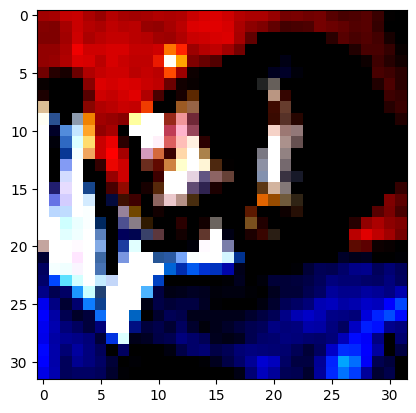

In [24]:
see_one_comparison(inputs, classes, predicts, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Real Label: ship predicted label: ship
torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


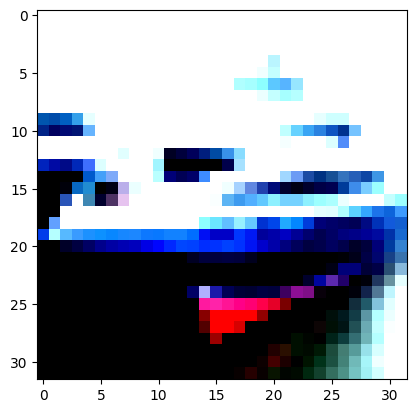

In [25]:
see_one_comparison(inputs, classes, predicts, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Real Label: frog predicted label: frog
torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


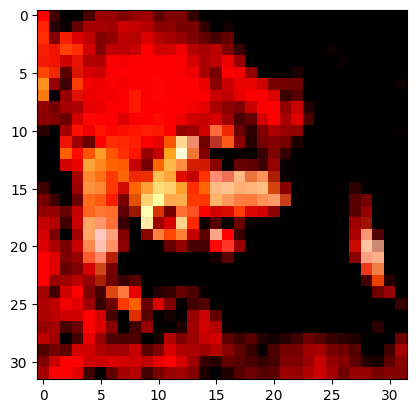

In [27]:
see_one_comparison(inputs, classes, predicts, 5)

In [28]:
torch.save(model.state_dict(), './models/densenet/densenet121_90_acc.pt')

In [ ]:
# model.load_state_dict(torch.load('./models/densenet/densenet121_20240416_01.pt'))